# Denoising Diffusion Implicit Models - DDIM

> Denoising Diffusion Implicit Models - DDIM


- skip_showdoc: true
- skip_exec: true


In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from fastAIcourse.datasets import *
from fastAIcourse.conv import *
from fastAIcourse.learner import *
from fastAIcourse.activations import *
from fastAIcourse.init import *
from fastAIcourse.sgd import *
from fastAIcourse.resnet import *
from fastAIcourse.augment import *
from fastAIcourse.accel import *
from fastAIcourse.fid import *

In [ ]:
from fastprogress.fastprogress import progress_bar

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [ ]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler

In [ ]:
class UNet(UNet2DModel): pass

In [ ]:
model = torch.load('models/fashion_ddpm3_25.pkl').cuda()
# model = torch.load('models/fashion_no-t.pkl').cuda()

In [ ]:
sched = DDPMScheduler(beta_end=0.01)

In [ ]:
x_t = torch.randn((4,1,32,32)).cuda()

In [ ]:
t = 99
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [ ]:
res = sched.step(noise, t, x_t)

In [ ]:
res.prev_sample.shape

torch.Size([4, 1, 32, 32])

In [ ]:
sz = (512,1,32,32)

In [ ]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 3min 34s, sys: 5.14 s, total: 3min 40s
Wall time: 3min 39s


In [ ]:
s = preds[-1].clamp(-0.5,0.5)*2

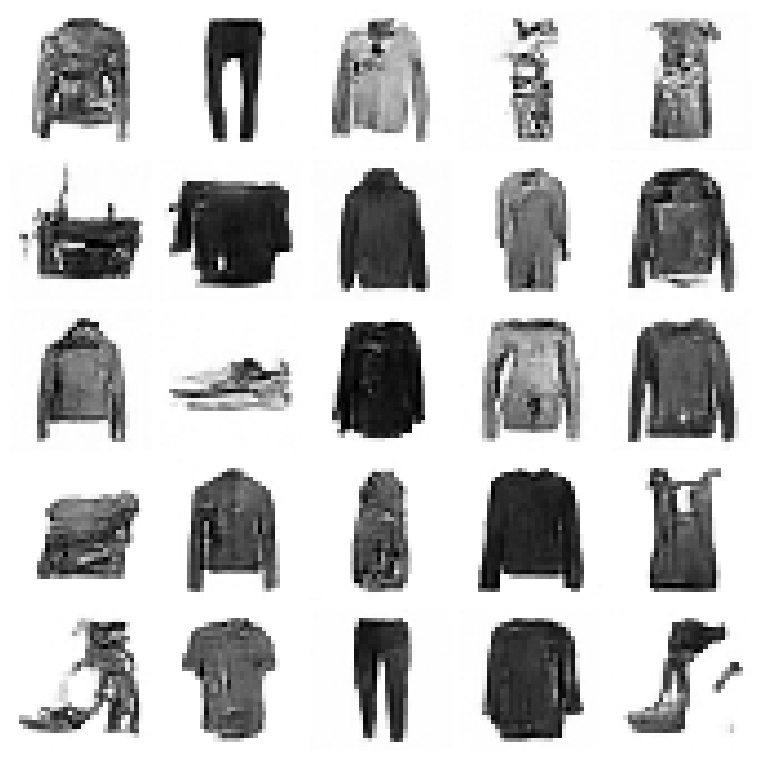

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
ie.fid(s),ie.kid(s)

(30.25244140625, 0.07350349426269531)

In [ ]:
ie.fid(xb),ie.kid(xb)

(1.296875, -0.00011661575990729034)

## Diffusers DDIM Scheduler

In [ ]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [ ]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)

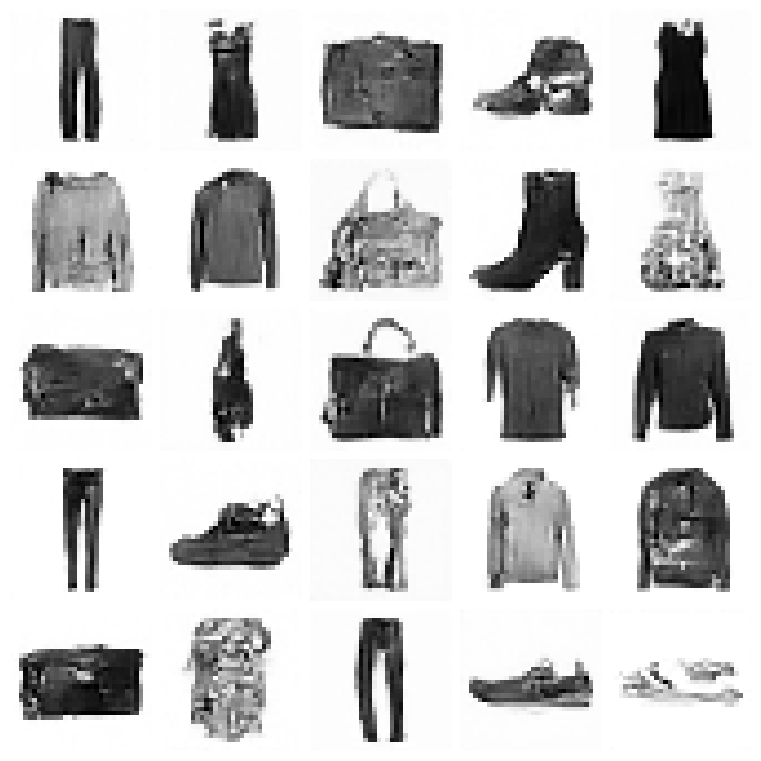

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s)

(36.6961669921875, 0.1079036071896553)

In [ ]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(33.8856201171875, 0.16268639266490936)

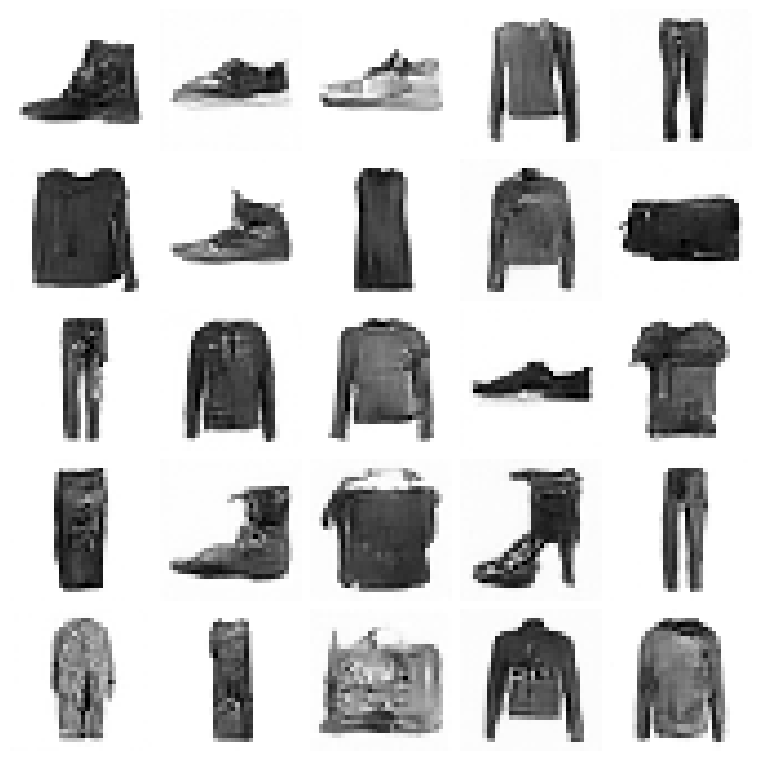

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [ ]:
s = (preds[-1]*2).clamp(-1,1)

In [ ]:
ie.fid(s),ie.kid(s)

(35.12646484375, 0.10706407576799393)

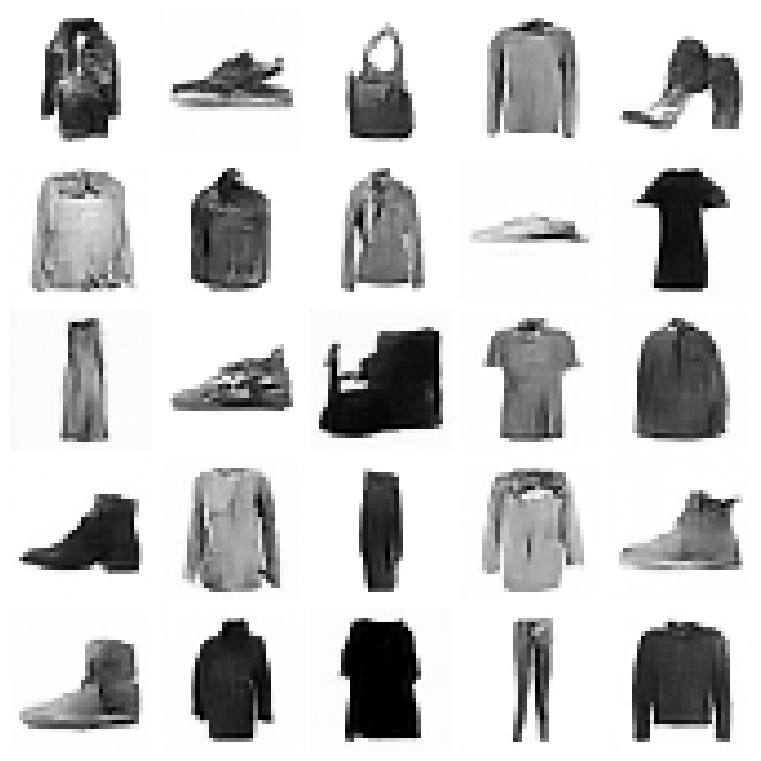

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(43.124267578125, 0.21125255525112152)

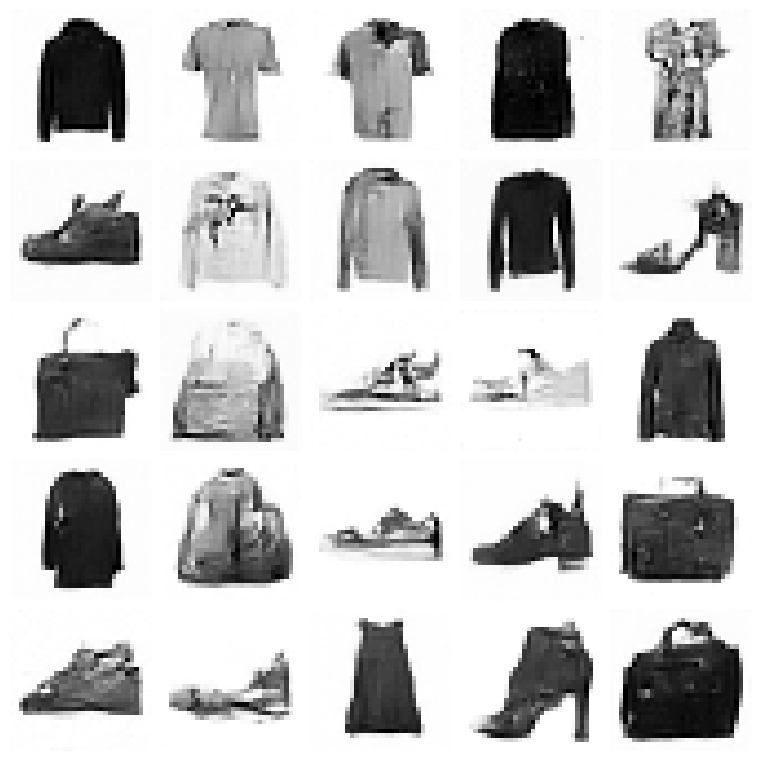

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(51.3458251953125, 0.21316410601139069)

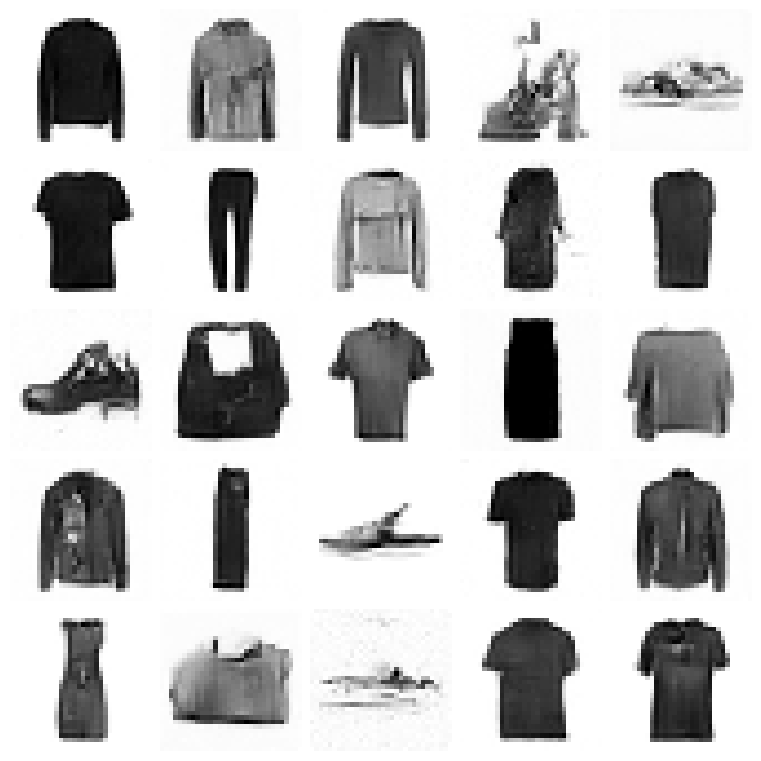

In [ ]:
show_images(s[:25], imsize=1.5)

## Implementing DDIM

In [ ]:
from types import SimpleNamespace

In [ ]:
n_steps=1000

In [ ]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [ ]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

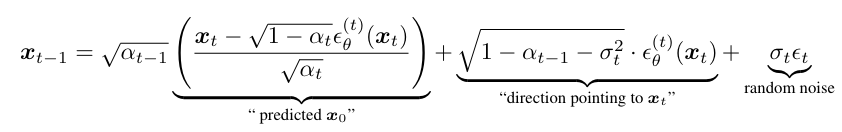

In [ ]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

In [ ]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample(ddim_step, model, sz, 1000, 10)

CPU times: user 21.7 s, sys: 450 ms, total: 22.2 s
Wall time: 22.2 s


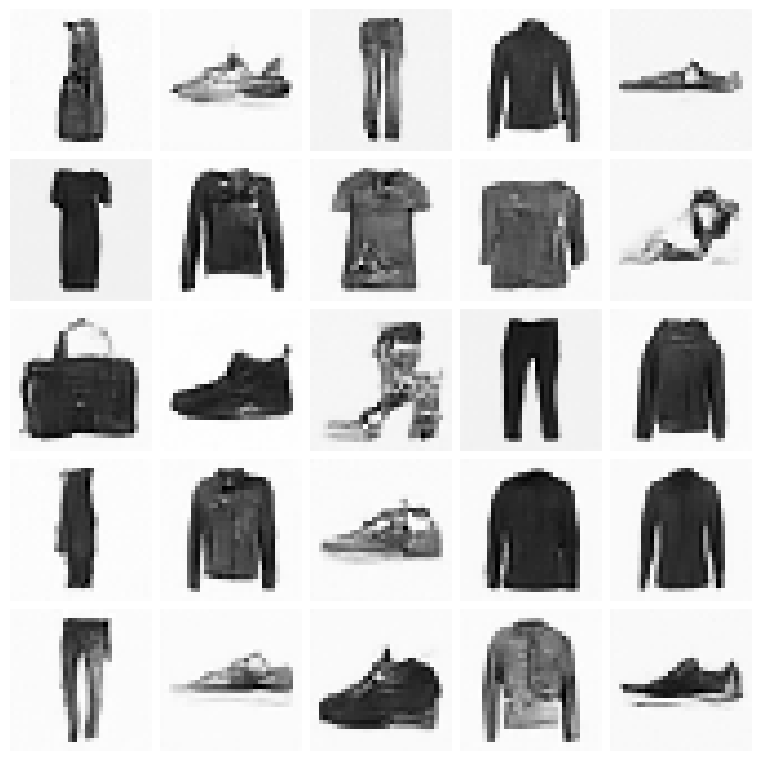

In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s)

(34.0198974609375, 0.11981192231178284)

## Triangular noise

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    t = np.random.triangular(0, 0.5, 1, (n,))*n_steps
    t = tensor(t, dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

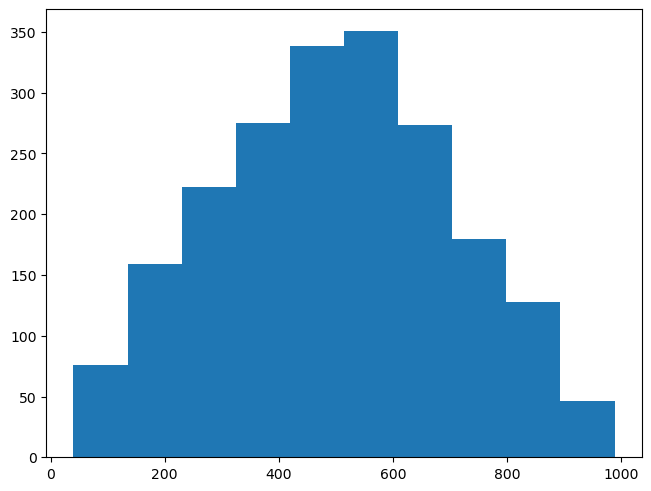

In [ ]:
(xt,t),ε = noisify(xb,abar)
plt.hist(t);